In [68]:
import torch
def leapfrog_step(F,p,x,eps):
    p_half = p + 0.5 * eps * F(x)  # F=-dV/dx
    x = x + eps * p_half
    p = p_half + 0.5 * eps * F(x)
    return p, x

def F_osc(x):
    return -x


    
    

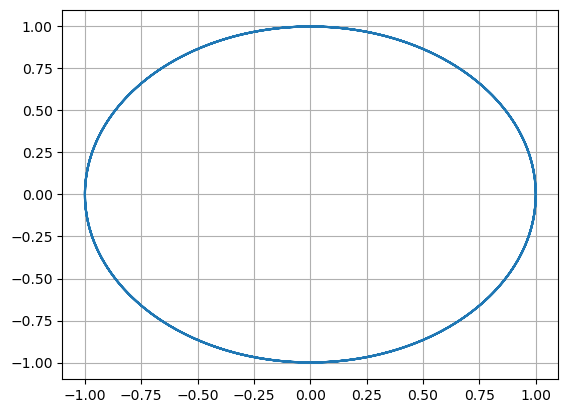

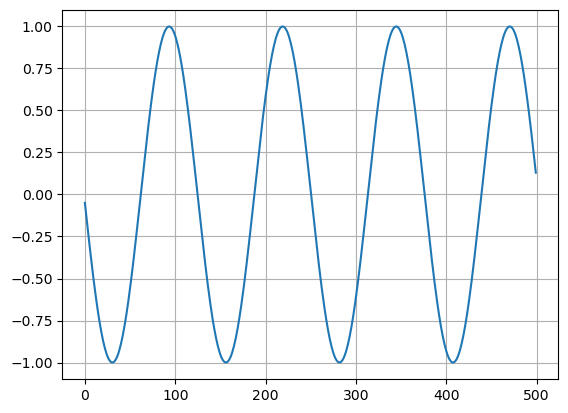

In [69]:
import matplotlib.pyplot as plt
x=torch.tensor([1.0,0.0])
p=torch.tensor([0.0,1.0])
eps = 0.05
P_hst=[]
X_hst=[]
n_steps = 500
for i in range(n_steps):
    p,x = leapfrog_step(F_osc,p,x,eps)
    X_hst.append(x[0])
    P_hst.append(p[0])
#print(X_hst)    
fig=plt.figure()
plt.plot(X_hst,P_hst)
plt.grid(True)
plt.show()
fig=plt.figure()
plt.plot(list(range(n_steps)),P_hst)
plt.grid(True)
plt.show()
    
    

In [ ]:
from tqdm import tqdm
import time


Times=[]
res=[]
def sweep(system,z,S,uniform_dist,un,model="none",d=a/N_nod):
    shift=uniform_dist.sample((N_samp,)).to(z.device)
    y=z+d*(2*shift-1)
    if model=="none":
        S_new=system.Full_S(y).to(z.device)
    else:    
        x,lad=model(y)
        S_new=system.Full_S(x).to(z.device)-lad
    dS=S_new-S
    prob=torch.exp(-dS)
    ind=un.sample((N_samp,)).to(z.device)<prob
    mask=ind.nonzero()
    if len(mask)>1:
        mask=mask.squeeze()
    if  len(mask)>0:
        S[mask]=S_new[mask]
        z[mask,:]=y[mask,:]    
    return torch.mean(ind.type('torch.FloatTensor'))    

def MCMC(system,z,model="none",d=a/N_nod,N_sweep=100):
    
    start=time.time()
    ar=0
    uniform_dist=torch.distributions.Uniform(torch.zeros(N_nod), torch.ones(N_nod))
    un=torch.distributions.Uniform(0, 1)

    if model=="none":
        S=system.Full_S(z).to(z.device)
    else:
        x , lad=model(z)
        S=system.Full_S(x).to(z.device)-lad   

    for i in range(N_sweep):
        if i%1000==0:
            if model=="none":
                x1=z
            else:    
                x1,_=model(z)
            print(torch.mean(x1**2),ar)
            res.append(torch.mean(x1**2).cpu())
            Times.append(time.time()-start)
                
        ar=sweep(system,z,S,uniform_dist,un,model,d)
    return z    
    

In [ ]:
def hmc_new(F,p,x,eps,n_steps):
    for i in range(n_steps):
         p,x = leap_frog_step(F,p,x,eps)
    return p,x   

In [59]:
x=torch.tensor([1.0,0.0])
p=torch.tensor([0.0,1.0])
q,y =  hmc_new(F_osc,p,x,0.01,1000)
print(p,x)
print(q,y)

tensor([0., 1.]) tensor([1., 0.])
tensor([0.3839, 0.9502]) tensor([ 0.9490, -0.2560])


In [70]:
import torch

def leapfrog_step(F,p,x,eps):
    p_half = p + 0.5 * eps * F(x)  # F=-dV/dx
    x = x + eps * p_half
    p = p_half + eps * F(x)
    return p, x

def hmc_new(F,p,x,eps,n_steps):
    for i in range(n_steps):
         p,x = leapfrog_step(F,p,x,eps)
    return p,x       


def hmc_sweep(system,x,S,normal_dist,un,eps=0.01,n_steps=100):
    p = normal_dist.sample((N_samp,)).to(z.device)
    q , y = hmc_new(system.F,p,x,eps,n_steps)
    S_new = system.Full_S(y).to(x.device)
    dS = S_new-S+q**2/2-p**2/2
    prob = torch.exp(-dS)
    ind = un.sample((N_samp,)).to(x.device)<prob
    mask = ind.nonzero()
    if len(mask)>1:
        mask = mask.squeeze()
    if  len(mask)>0:
        S[mask] = S_new[mask]
        z[mask,:] = y[mask,:]    
    return torch.mean(ind.type('torch.FloatTensor'))    

def HMC(system,x,eps=0.01,n_steps=100,N_sweep=100):

    ar=0
    normal_dist=torch.distributions.Normal(torch.zeros(N_nod), torch.ones(N_nod))
    un=torch.distributions.Uniform(0, 1)
    S=system.Full_S(z).to(z.device)
    
    for i in range(N_sweep):
        ar = hmc_sweep(system,z,S,normal_dist,un,eps,n_steps)
    return z    